# CNN Use Case -- Kaggle Competition Dataset
References:
 - https://www.kaggle.com/competitions/2020-2021-cnn-contest/data
 - https://keras.io/examples/keras_recipes/tfrecord/
 - https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices
 - https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438
 - https://www.tensorflow.org/api_docs/python/tf/keras/applications/xception/Xception

## Download and Read in training dataset

In [1]:
!pwd

/content


In [2]:
# Download source data from bucket
from google.colab import auth
auth.authenticate_user()
!gsutil cp gs://mgsc-ai-project/training.csv .

Copying gs://mgsc-ai-project/training.csv...
| [1 files][160.9 MiB/160.9 MiB]                                                
Operation completed over 1 objects/160.9 MiB.                                    


In [3]:
# Import modules
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.model_selection import train_test_split

In [34]:
df = pd.read_csv("training.csv")

In [35]:
df.columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')

## Data Cleaning and Transformation

### Remove columns with too many null values

In [36]:
df.columns[np.where(df.isnull().sum()/df.shape[0] < 0.5)]

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')

In [37]:
data_full = df[['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
                'right_eye_center_y', 'nose_tip_x', 'nose_tip_y',
                'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y', 'Image']].dropna()

In [38]:
del df

### Preprocessing

In [39]:
data_full['Image'] = data_full['Image'].str.split().apply(lambda x: np.array(list(map(int, x))))

In [10]:
data_full['Image']

0       [238, 236, 237, 238, 240, 240, 239, 241, 241, ...
1       [219, 215, 204, 196, 204, 211, 212, 200, 180, ...
2       [144, 142, 159, 180, 188, 188, 184, 180, 167, ...
3       [193, 192, 193, 194, 194, 194, 193, 192, 168, ...
4       [147, 148, 160, 196, 215, 214, 216, 217, 219, ...
                              ...                        
4995    [203, 199, 196, 192, 190, 186, 174, 201, 216, ...
4996    [114, 128, 147, 162, 167, 169, 173, 178, 177, ...
4997    [104, 93, 83, 85, 87, 88, 83, 68, 53, 36, 39, ...
4998    [200, 199, 199, 205, 178, 103, 61, 76, 65, 63,...
4999    [79, 88, 90, 74, 43, 27, 34, 49, 52, 44, 39, 3...
Name: Image, Length: 4954, dtype: object

In [11]:
data_full.shape

(4954, 9)

In [12]:
data_x = data_full['Image']
data_y = data_full.drop(columns=['Image'])

In [13]:
del data_full

In [14]:
len(data_x[0])

9216

In [15]:
IMAGE_SIZE = [96,96]
DATA_SIZE = 4954

In [16]:
img = np.vstack(data_x.values).reshape((4954,96,96))
X_matrix = tf.cast(img,tf.int64)

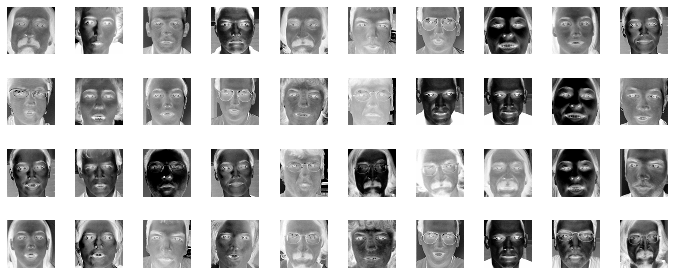

In [41]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(img[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [17]:
output_attributes = data_y.columns

In [18]:
y_matrix = tf.cast(data_y.values, tf.float32)

In [19]:
image_tf_data = tf.data.Dataset.from_tensor_slices((X_matrix, y_matrix)).batch(1)

In [20]:
# https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438
def get_dataset_partitions_tf(ds, ds_size, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [21]:
train_set, val_set, test_set = get_dataset_partitions_tf(image_tf_data, DATA_SIZE)

In [22]:
del X_matrix
del y_matrix

In [23]:
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=20, decay_rate=0.96, staircase=True
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "checkpoint_model.h5", save_best_only=True
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

## Basic CNN Architecture: Alexnet

In [27]:
def make_alexnet_model():
  model_base = keras.models.Sequential([
      keras.layers.Conv2D(filters=96, kernel_size=(3,3), strides=(2,2), activation='relu', input_shape=[*IMAGE_SIZE, 1], name = "conv1"),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), name = "pool1"),
      keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same", name = "conv2"),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), name = "pool2"),
      keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same", name = "conv3"),
      keras.layers.BatchNormalization(),
      keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same", name = "conv4"),
      keras.layers.BatchNormalization(),
      keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same", name = "conv5"),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), name = "pool3"),
      keras.layers.Flatten(),
      keras.layers.Dense(4096, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(4096, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(8)
  ])
  
  model_base.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="mse",
        metrics="mae",
    )
    
  return model_base

In [29]:
model_alexnet = make_alexnet_model()
history = model_alexnet.fit(
    train_set,
    epochs=100,
    validation_data=val_set,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
3467/3467 [==============================] - 35s 10ms/step - loss: 1647913.3750 - mae: 343.2583 - val_loss: 762930.7500 - val_mae: 513.2805
Epoch 2/100
3467/3467 [==============================] - 34s 10ms/step - loss: 19628.7227 - mae: 89.5659 - val_loss: 752785.1250 - val_mae: 518.9748
Epoch 3/100
3467/3467 [==============================] - 33s 10ms/step - loss: 17118.7969 - mae: 87.7231 - val_loss: 806694.3125 - val_mae: 530.4143
Epoch 4/100
3467/3467 [==============================] - 33s 10ms/step - loss: 16299.3105 - mae: 84.9691 - val_loss: 747440.7500 - val_mae: 507.4884
Epoch 5/100
3467/3467 [==============================] - 33s 10ms/step - loss: 17752.2012 - mae: 87.9181 - val_loss: 718338.1250 - val_mae: 502.7084
Epoch 6/100
3467/3467 [==============================] - 33s 10ms/step - loss: 16980.1250 - mae: 87.2592 - val_loss: 732817.9375 - val_mae: 506.5710
Epoch 7/100
3467/3467 [==============================] - 33s 10ms/step - loss: 19466.5918 - mae: 89.228

In [42]:
model_alexnet.evaluate(test_set)

744/744 [==============================] - 3s 3ms/step - loss: 743431.7500 - mae: 519.9500


[743431.75, 519.9500122070312]

## Xception

In [31]:
def make_model():
    base_model = tf.keras.applications.Xception(
        input_shape=[*IMAGE_SIZE, 3], include_top=False, weights="imagenet")
    
    base_model.trainable = False
    
    inputs = tf.keras.layers.Input(shape=[*IMAGE_SIZE, 1])
    img_conc = tf.keras.layers.Concatenate()([inputs, inputs, inputs])  
    x = tf.keras.applications.xception.preprocess_input(img_conc)
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(20, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.7)(x)
    outputs = tf.keras.layers.Dense(8)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="mse",
        metrics="mae",
    )

    return model

In [32]:
model_xception = make_model()
history = model_xception.fit(
    train_set,
    epochs=100,
    validation_data=val_set,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

83697664/83683744 [==============================] - 0s 0us/step
Epoch 1/100
3467/3467 [==============================] - 33s 9ms/step - loss: 855.3926 - mae: 23.2961 - val_loss: 274.6339 - val_mae: 14.4904
Epoch 2/100
3467/3467 [==============================] - 30s 9ms/step - loss: 814.3738 - mae: 22.6254 - val_loss: 262.6161 - val_mae: 14.2410
Epoch 3/100
3467/3467 [==============================] - 30s 8ms/step - loss: 803.1224 - mae: 22.3522 - val_loss: 275.5918 - val_mae: 14.6392
Epoch 4/100
3467/3467 [==============================] - 30s 8ms/step - loss: 787.3615 - mae: 22.2535 - val_loss: 271.4980 - val_mae: 14.4424
Epoch 5/100
3467/3467 [==============================] - 29s 8ms/step - loss: 780.5558 - mae: 22.2099 - val_loss: 274.4127 - val_mae: 14.5029
Epoch 6/100
3467/3467 [==============================] - 29s 8ms/step - loss: 813.3966 - mae: 22.6764 - val_loss: 294.0844 - val_mae: 14.9992
Epoch 7/100
3467/3467 [==============================] - 30s 9ms/step - loss: 789.7

In [43]:
model_xception.evaluate(test_set)

744/744 [==============================] - 6s 7ms/step - loss: 281.4579 - mae: 14.8237


[281.45794677734375, 14.823661804199219]

In [44]:
help(tf.keras.applications)

Help on package keras.api._v2.keras.applications in keras.api._v2.keras:

NAME
    keras.api._v2.keras.applications - Public API for tf.keras.applications namespace.

PACKAGE CONTENTS
    densenet (package)
    efficientnet (package)
    efficientnet_v2 (package)
    imagenet_utils (package)
    inception_resnet_v2 (package)
    inception_v3 (package)
    mobilenet (package)
    mobilenet_v2 (package)
    mobilenet_v3 (package)
    nasnet (package)
    resnet (package)
    resnet50 (package)
    resnet_v2 (package)
    vgg16 (package)
    vgg19 (package)
    xception (package)

FILE
    /usr/local/lib/python3.7/dist-packages/keras/api/_v2/keras/applications/__init__.py


